In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as sm
import random
from sklearn.linear_model import LinearRegression, LogisticRegression
from tabulate import tabulate
import pylab

In [ ]:
df = pd.read_csv("/content/cleaned_data.csv")
df['Debtor'] = df['Debtor'].map({'Yes': 1, 'No': 0})
df['Scholarship holder'] = df['Scholarship holder'].map({'Yes': 1, 'No': 0})
np.random.seed(1)
sampled_data=df.sample(n=200)
## taking only the columns we are working with
covariates=sampled_data[['Debtor','Curricular units 1st sem (grade)','GDP']]
Y=sampled_data['Curricular units 2nd sem (grade)']
covariates_np=covariates.to_numpy()

In [ ]:
df["Gender"]

,Gender
0,Male
1,Male
2,Male
3,Female
4,Female
...,...
4419,Male
4420,Female
4421,Female
4422,Female


**Part A**

In [ ]:
B=400

1)

a..

In [ ]:
alpha = 0.05
X = np.array(sampled_data[['Debtor','Curricular units 1st sem (grade)','GDP']])
X=np.insert(X,0,np.ones(X.shape[0]),axis=1)
y = sampled_data['Curricular units 2nd sem (grade)']
reg = LinearRegression(fit_intercept=False).fit(X, y)
SSE = sum([(reg.predict([X[i]])[0] - y.iloc[i])**2 for i in range(len(X))])
degrees_freedom =  X.shape[0] - (X.shape[1])
MSRes =  SSE / degrees_freedom
sigma_epsilon_squared = MSRes
C = np.linalg.inv(X.T @ X)
intrval_quantile = stats.t.ppf(q=(1 - alpha / 2), df=(X.shape[0] - (X.shape[1])))

confidence_intervals = [[beta - intrval_quantile * (sigma_epsilon_squared * C[i][i]) ** 0.5,
                         beta + intrval_quantile * (sigma_epsilon_squared * C[i][i]) ** 0.5]
                        for i, beta in enumerate(list(reg.coef_))]

print("The CI for beta over the sampled data:")
for i, feature in enumerate(["Intercept",'Debtor','Curricular units 1st sem (grade)','GDP']):
    print(f"The beta_{feature} CI is", confidence_intervals[i])

The CI for beta over the sampled data:
The beta_Intercept CI is [-0.1714158182131129, 1.9430005063525084]
The beta_Debtor CI is [-2.640756124184122, -0.44600409957892784]
The beta_Curricular units 1st sem (grade) CI is [0.8078121252014012, 0.9797431878276603]
The beta_GDP CI is [-0.05186221414302267, 0.26512837377957865]


b.

In [ ]:
alpha = 0.05
z_quantile = stats.norm.ppf(1 - (alpha / 2))
X = np.array(sampled_data[['Debtor','Curricular units 1st sem (grade)','GDP']])
y = sampled_data['Curricular units 2nd sem (grade)']
X=np.insert(X,0,np.ones(X.shape[0]),axis=1)
beta = np.linalg.inv(X.T @ X) @ X.T @ y
ci_normal_boot = []
sum_boot_strap_betas = np.zeros(len(beta))
square_boot_strap_betas = np.zeros(len(beta))
boot_strap_betas = []
for iteration in range(B):
    boot_strap_df = sampled_data.sample(200, replace=True)

    X_iteration = np.insert(np.array(boot_strap_df[['Debtor','Curricular units 1st sem (grade)','GDP']]), 0, np.ones(200), axis=1)
    Y_iteration = np.array(boot_strap_df['Curricular units 2nd sem (grade)'])

    beta_iteration = np.linalg.inv(X_iteration.T @ X_iteration) @ X_iteration.T @ Y_iteration
    boot_strap_betas.append(beta_iteration)
    sum_boot_strap_betas += beta_iteration.reshape(4,)
    square_boot_strap_betas += beta_iteration.reshape(4,) ** 2

se_boot = (square_boot_strap_betas / B - (sum_boot_strap_betas / B) ** 2) ** 0.5

for i, b in enumerate(list(reg.coef_)):
    ci_normal_boot.append([b - z_quantile * se_boot[i], b + z_quantile * se_boot[i]])

print("The CI for beta over the sampled data using s.e._bootstrap:")
for i, feature in enumerate(["Intercept",'Debtor','Curricular units 1st sem (grade)','GDP']):
    print(f"The beta_{feature} CI is", ci_normal_boot[i])

The CI for beta over the sampled data using s.e._bootstrap:
The beta_Intercept CI is [-0.23175947310558342, 2.003344161244979]
The beta_Debtor CI is [-3.2674946752894645, 0.18073445152641465]
The beta_Curricular units 1st sem (grade) CI is [0.8077861982278899, 0.9797691148011717]
The beta_GDP CI is [-0.042412721366091755, 0.25567888100264774]


c.

In [ ]:
beta =list(reg.coef_)
ci_pivot_boot = []
bootstrap_betas_per_features = [[], [], [], []]

for coef in boot_strap_betas:
    for i in range(len(beta)):
        bootstrap_betas_per_features[i].append(coef[i])

for i in range(len(beta)):
    values = bootstrap_betas_per_features[i]
    values.sort()
    first_quantile = values[int(B * (1 - alpha/2))]
    second_quantile = values[int(B * (alpha/2))]
    ci_pivot_boot.append([2*beta[i] - first_quantile, 2*beta[i] - second_quantile])

print("The CI for beta over the sampled data using pivotal intervals:")
for i, feature in enumerate(["Intercept",'Debtor','Curricular units 1st sem (grade)','GDP']):
    print(f"The beta_{feature} CI is", ci_pivot_boot[i])

The CI for beta over the sampled data using pivotal intervals:
The beta_Intercept CI is [-0.4732646144812276, 1.7305494094998024]
The beta_Debtor CI is [-3.1599898315617407, 0.2976422004422812]
The beta_Curricular units 1st sem (grade) CI is [0.8256351829300803, 0.9872945421925423]
The beta_GDP CI is [-0.036439387431081216, 0.24856169650662324]


In [ ]:
ci_quantile_boot = []

for i in range(len(beta)):
    values = bootstrap_betas_per_features[i]
    first_quantile = values[int(B * (1 - alpha/2))]
    second_quantile = values[int(B * (alpha/2))]
    ci_quantile_boot.append([second_quantile, first_quantile])
print("The CI for beta over the sampled data using percentile intervals:")
for i, feature in enumerate(["Intercept",'Debtor','Curricular units 1st sem (grade)','GDP']):
    print(f"The beta_{feature} CI is", ci_quantile_boot[i])

The CI for beta over the sampled data using percentile intervals:
The beta_Intercept CI is [0.041035278639593026, 2.244849302620623]
The beta_Debtor CI is [-3.384402424205331, 0.07322960779869114]
The beta_Curricular units 1st sem (grade) CI is [0.8002607708365193, 0.9619201300989813]
The beta_GDP CI is [-0.03529553687006727, 0.2497055470676372]


2)

In [ ]:
X_full = np.insert(np.array(df[['Debtor','Curricular units 1st sem (grade)','GDP']]), 0, np.ones(len(df)), axis=1)
Y_full = np.array(df['Curricular units 2nd sem (grade)'])

beta_hat = np.linalg.inv(X_full.T @ X_full) @ X_full.T @ Y_full

method_CI = [confidence_intervals, ci_normal_boot, ci_pivot_boot, ci_quantile_boot]
features = ["Intercept",'Debtor','Curricular units 1st sem (grade)','GDP']
for i, coef in enumerate(beta_hat):
    print("-" * 100)
    print(f"beta_{features[i]}:")
    for j, method in enumerate(["normal approximation",
                                "bootstrap normal approximation", "pivotal bootstrap", "quantiles bootstrap"]):
        print(method, "length:", method_CI[j][i][1] - method_CI[j][i][0],
              "beta in CI:", method_CI[j][i][0] <= coef <= method_CI[j][i][1])
    print()

----------------------------------------------------------------------------------------------------
beta_Intercept:
normal approximation length: 2.1144163245656213 beta in CI: True
bootstrap normal approximation length: 2.2351036343505624 beta in CI: True
pivotal bootstrap length: 2.20381402398103 beta in CI: True
quantiles bootstrap length: 2.20381402398103 beta in CI: True

----------------------------------------------------------------------------------------------------
beta_Debtor:
normal approximation length: 2.1947520246051946 beta in CI: True
bootstrap normal approximation length: 3.448229126815879 beta in CI: True
pivotal bootstrap length: 3.457632032004022 beta in CI: True
quantiles bootstrap length: 3.457632032004022 beta in CI: True

----------------------------------------------------------------------------------------------------
beta_Curricular units 1st sem (grade):
normal approximation length: 0.17193106262625912 beta in CI: True
bootstrap normal approximation lengt

As we can see from the printed information above the CI's for the coeffecients,we see the length of the four CI's for each coeffecient differs but we can see that for all the coeffecients we get the same CI length for quantiles bootstrap CI and pivotal bootstrap CI.

3)

a.

In [ ]:
np.random.seed(1)
sampled_data2 = df.drop(list(sampled_data.index)).sample(n=100)
X_test = np.insert(np.array(sampled_data2[['Debtor','Curricular units 1st sem (grade)','GDP']]), 0, np.ones(100), axis=1)
y_label = sampled_data2['Curricular units 2nd sem (grade)']
y_predicted = X_test @ beta

b.

In [ ]:
pred_in_CI_indicators=[]

for i, x in enumerate(X_test):
    cis_pivot_boot_for_prediction = []
    bootstrap_predictions = []

    for boot_beta in boot_strap_betas:
        prediction = x @ boot_beta
        bootstrap_predictions.append(prediction)

    bootstrap_predictions.sort()
    first_quantile = bootstrap_predictions[int(B * (1 - alpha/2))]
    second_quantile = bootstrap_predictions[int(B * (alpha/2))]
    cis_pivot_boot_for_prediction = [2 * y_predicted[i] - first_quantile,
                                     2 * y_predicted[i] - second_quantile]

    pred_in_CI_indicators.append(cis_pivot_boot_for_prediction[0] <= list(y_label)[i] <= cis_pivot_boot_for_prediction[1])

c.

In [ ]:
print("The percent of CIs that contain the real value Y_new is",
      sum(pred_in_CI_indicators) / len(pred_in_CI_indicators))

The percent of CIs that contain the real value Y_new is 0.46


Althought 46% is far from 95% confidence level we chose for the CI, this happens because we have dismissed the noise factor since we are looking at the CI for the expectation of Ynew given Xnew and not for Ynew itself. Thus, we have a narrower CI.

d.

In order to the confidence interval, we have to calculate the variance of the estimator for the Ynew plus the estimator for the noise. So we will do bootstraping to get each time the estimator for Ynew, and we will do bootstraping to get the estimator for the noise. At the end we calculate the confidence interval using the normal approximation confidence intervals.

**Part B:**

Our Test Question: does the first semester grade different among Male and Female?

1)

Does the  first semester grade among females (denoted  Xfemales  ) is less than the  first semester grade among males (denoted  Xmales  ) in the usual stochastic order?

In other words, the question is: does the following hold:  Xmales ≻ Xfemales

2)

In [ ]:
np.random.seed(1)
sample = df.sample(n=200, random_state=10)

3)

a.

We define  μ1  and  μ2  to be the expectations of  Xfemales  and  Xmales  respectively. We now estimate them. As we learned, the unbiased estimator to the expectation is the mean. We estimate their difference  δ  by the differnce of the means. By the delta method we get that the estimator for  δ  is the difference of the means (MLE's for the variables).

In [ ]:
categorical_variable='Gender'
means = sample[['Gender','Curricular units 1st sem (grade)']].groupby(categorical_variable).mean()
categorical_values=['Female','Male']
continuous_variable='Curricular units 1st sem (grade)'
mean_cat_1 = means.loc[categorical_values[0], continuous_variable]
mean_cat_2 = means.loc[categorical_values[1], continuous_variable]

delta_hat = mean_cat_1 - mean_cat_2

In [ ]:
print(f'estimator for mu1 is: {mean_cat_1}')
print(f'estimator for mu2 is: {mean_cat_2}')
print(f'estimator for delta is: {delta_hat}')

estimator for mu1 is: 11.315553068605087
estimator for mu2 is: 8.83190821697864
estimator for delta is: 2.4836448516264475


also we want to gain some knowledge about the distribution of the data. To do that, we plot two histograms for the data in the sample, that approximate the density of the two random variables:

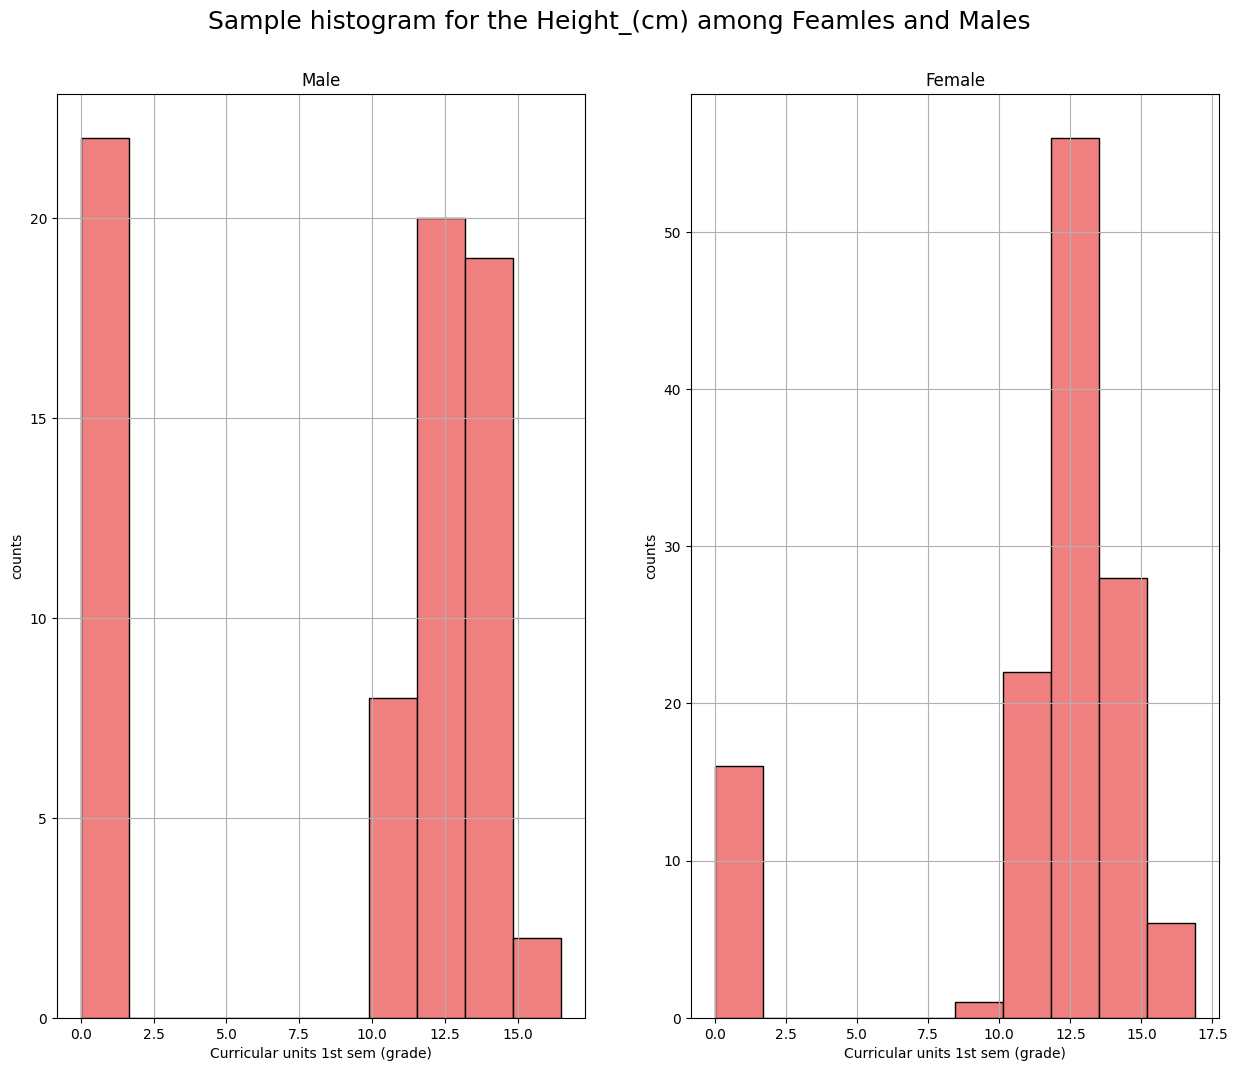

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Sample histogram for the Curricular units 1st sem (grade) among Feamles and Males", fontsize=18, y=0.95)

categ = sample['Gender'].unique()
nc = math.ceil(len(categ)/2)
nrows=nc
ncols=2

for n, c in enumerate(categ):
  data = sample[sample['Gender']==c]['Curricular units 1st sem (grade)']
  mean = data.mean()
  median = data.median()
  ax = plt.subplot(nrows, ncols, n + 1)
  data.hist(ax=ax, bins=10, ec="black", color="lightcoral")
  ax.set(ylabel="counts", xlabel='Curricular units 1st sem (grade)',title=str(c))
plt.show()

According to the histograms, we are not able to determine what is the distribution of the two random variables that we explore. Thus, we have no information about the statistical model of the data .

b.

Next, we calculate a CI for the difference between the expected value. We use what we learned in the course statistics 1, for building a CI for the expected value of the differennce of two independent samples with identical unknown variance. We note that this test is intended for normally distributed data, so that this is only an approximated CI.

we will conduct an F test with α=0.05 to check if the null hypothesis that we have equal variance between females and males holds:

In [ ]:
Females = sample[sample["Gender"] == "Female"]
Males = sample[sample["Gender"] == "Male"]

variances=sample.groupby(categorical_variable).var(numeric_only=True)
variance_category1=variances.loc[categorical_values[0],continuous_variable]
variance_category2=variances.loc[categorical_values[1],continuous_variable]
F_test_statistic = variance_category1/variance_category2
F_quantile = stats.f.ppf(0.95,len(Females)-1,len(Males)-1)
testResult = F_test_statistic > F_quantile # true iff we reject H_0
print("Do we reject the Null Hypothesis?")
if testResult==False:
  print('No')
else:
  print('Yes')

Do we reject the Null Hypothesis?
No


as we see we will not reject the null hypotheses for  α=0.05  thus we conclude that it is safe to say that the variances are equal

In [ ]:

n1 = len(Females)
n2 = len(Males)

print(f'Number of Females in the sample: {n1}')
print(f'Number of Males in the sample: {n2}')

se_Females = (sum((Females["Curricular units 1st sem (grade)"] - mean_cat_1) ** 2)) / (n1 - 1)
se_Males = (sum((Males["Curricular units 1st sem (grade)"] - mean_cat_2) ** 2)) / (n2 - 1)

sp = (((n1 - 1) * se_Females + (n2 - 1) * se_Males) / (n1 + n2 - 2)) ** 0.5
delta_ci_meu = [delta_hat - 2 * sp * (1 / n1 + 1 / n2) ** 0.5, delta_hat + 2 * sp * (1 / n1 + 1 / n2) ** 0.5]
print(f'CI is: {delta_ci_meu}')

Number of Females in the sample: 129
Number of Males in the sample: 71
CI is: [0.9817103419769839, 3.985579361275911]


c.

In [ ]:
means = df[['Gender','Curricular units 1st sem (grade)']].groupby(categorical_variable).mean()
mean_cat_1 = means.loc[categorical_values[0], continuous_variable]
mean_cat_2 = means.loc[categorical_values[1], continuous_variable]

delta_hat_total= mean_cat_1 - mean_cat_2

is_in_CI = delta_hat_total <= delta_ci_meu[1] and delta_hat_total >= delta_ci_meu[0]
print(f'the delta on all data is in the CI: {is_in_CI}')

the delta on all data is in the CI: True


d.

Next, we test the hypothesis of question 1 using the wald's test and the permutation test.

We start with the Wald's test, with α = 0.05 - as we saw in class (where X, Y are the two random variables we have here: $X_{males}$
  and  $X_{females}$
 ):

$$H_0: δ = 0$$

$$H_1: \delta > 0$$

$$T.s: W = \frac{X_n - Y_m}{\sqrt{\frac{S^2_x}{n}+\frac{S^2_y}{m}}}$$

$$R.R: W > Z_{α}$$

In [ ]:
s_x = (sum((Males['Curricular units 1st sem (grade)'] - mean_cat_2) ** 2)) / n2
s_y = (sum((Females['Curricular units 1st sem (grade)'] - mean_cat_1) ** 2)) / n1

W = (mean_cat_2 - mean_cat_1) / (s_x / n2 + s_y / n1) ** 0.5
z = stats.norm.ppf(0.95)
print('We reject H0' if W> z else 'We do not reject H0')

We do not reject H0


We now use a permutation test, as we saw in class:

$$H_0: F_X = F_Y$$

$$H_1: F_X > F_Y$$

$$T.s: X_n - Y_m$$

$$p_{value} = \frac{Σ^{(^N_n)}_j I_{T_j > T_0}}{(^N_n)}$$

$$R.R: p_{value} < α$$

In [ ]:
import random

random.seed(31)


counter = 0
for b in range(B):
    indices = sample.index.tolist()
    Females_indices = random.sample(indices, n1)
    Males_indices = set(indices).difference(set(Females_indices))

    mu_1_perm = sample["Curricular units 1st sem (grade)"][list(Females_indices)].mean()
    mu_2_perm = sample["Curricular units 1st sem (grade)"][list(Males_indices)].mean()

    if mu_1_perm - mu_2_perm >= delta_hat:
        counter += 1

pval = counter/B

print("p-value is: ", pval)
print('We reject H0' if 0.05 > pval else 'We do not reject H0')

p-value is:  0.0
We reject H0


**notice if instead of B in the P_val we used $(^N_n)$** where N=n1+n2 and n=n2 we will get a very large number of permutations, so we chose to only divide by B and do the sampling of the ranks B times since becuase of the randomality it is not guaranteed that we get all the different ranks permutations assigned to both females group and males group we might get the same permutation twice.

4)

a.

In [ ]:
m1_hat = np.quantile(Females["Curricular units 1st sem (grade)"], 0.5)
m2_hat = np.quantile(Males["Curricular units 1st sem (grade)"], 0.5)
delta_m = m2_hat - m1_hat

print(f'estimator for m1 is: {m1_hat}')
print(f'estimator for m2 is: {m2_hat}')
print(f'estimator for m2-m1 is: {delta_m}')

estimator for m1 is: 12.59125
estimator for m2 is: 12.0
estimator for m2-m1 is: -0.5912500000000005


b.

In [ ]:
def quant(lst, val):
  lst.sort()
  n = len(lst)
  for i, num in enumerate(lst):
    if (i+1) / n >= val :
      return num
  return num

In [ ]:
B = 400
bootstrap_deltas = np.zeros(B)
Females_np= Females["Curricular units 1st sem (grade)"].to_numpy()
Males_np = Males["Curricular units 1st sem (grade)"].to_numpy()

for i in range(B):
 females_sample = np.random.choice(Females_np, size=Females_np.shape[0],
 replace=True)
 Males_sample = np.random.choice(Males_np, size=Males_np.shape[0],
 replace=True)
 bootstrap_delta = np.median(Males_sample) - np.median(females_sample)
 bootstrap_deltas[i] = bootstrap_delta
lb = quant(bootstrap_deltas, 0.025)
ub = quant(bootstrap_deltas, 0.975)
print(f"The quantile based CI, for median difference is: {[lb, ub]}")

The quantile based CI, for median difference is: [-1.4000000000000004, 0.0]


c.

In [ ]:
total_Females = df[df["Gender"] == "Female"]
total_Males = df[df["Gender"] == "Male"]

m2_hat = np.quantile(total_Males["Curricular units 1st sem (grade)"], 0.5)
m1_hat = np.quantile(total_Females["Curricular units 1st sem (grade)"], 0.5)
delta_m_total = m2_hat - m1_hat

print(f'estimator for m1 is: {m1_hat}')
print(f'estimator for m2 is: {m2_hat}')
print(f'estimator for m2-m1 is: {delta_m_total}')

estimator for m1 is: 12.5
estimator for m2 is: 11.833333333333334
estimator for m2-m1 is: -0.6666666666666661


We got that the estimator for delta is in the CI.

d.

In [ ]:
B = 1000
counter = 0
for b in range(B):
    indices = sample.index.tolist()
    Females_indices = random.sample(indices, n1)
    Males_indices = set(indices).difference(set(Females_indices))

    m_1_perm = sample["Curricular units 1st sem (grade)"][list(Females_indices)].median()
    m_2_perm = sample["Curricular units 1st sem (grade)"][list(Males_indices)].median()

    if m_2_perm - m_1_perm >= delta_m:
        counter += 1

pval = counter/B

print("p-value is: ", pval)
print('We reject H0' if 0.05 > pval else 'We do not reject H0')

p-value is:  0.975
We do not reject H0


e.

t-test: designed for normally distributed data - which is obviously not the case here, as we have shown the histogrmas we saw earlier are not even symmetric.

Wald's test: We can use wald's test even though the data is not normally distributed, as we saw in the lecture but only if the test statistic is asymptotically normal. notice that we do not know the statistical model thus we can not know if the medians difference estimator is an MLE so we are not certian that the test statistic is indeed asymptotically normal according to lecture. thus the only way is to check if it is asymptotically normal which we do not have enough information to check if this assumption holds, so we can't use wald's test here.

5)

In [ ]:
sample_ranked = sample.copy()
sample_ranked['rank'] = sample_ranked["Curricular units 1st sem (grade)"].rank()
s1 = sum(sample_ranked[sample_ranked["Gender"]=='Male']["rank"])
print(f"The sum of Males ranks is {s1}")

The sum of Males ranks is 6157.5


we will use wilcoxon rank-sum test:

In [ ]:
B = 10000
rej = 0

for _ in range(B):
 Males_indices = np.random.choice(n1+n2, n1, replace=False)
 permutation_Males_ranks = sample_ranked["rank"].to_numpy()[Males_indices]
 permutation_s1 = sum(permutation_Males_ranks)
 rej += int(permutation_s1 >= s1)
p_value = rej / B

print(f"The p-value is: {p_value}")
if p_value > 0.05:
  print("Do not reject H0")
else:
  print('Reject H0')

The p-value is: 1.0
Do not reject H0


We can use the normal approximation since as we saw in class, the sum of ranks of a random permutation is approximately normally distributed

In [ ]:
from scipy.stats import norm

expected = n2 * (n1+n2 + 1) / 2
variance = expected * n1 / 6
w = (s1 - expected) / (variance)**0.5
quantile=norm.cdf(0.95)
if w >=quantile:
  print("reject H0")
else:
  print('do not Reject H0')

do not Reject H0


in the two tests we got that we should not reject H0

6)

The results in all 4-5 tests we have performed are conclusive - do not reject the null hypothesis,while in 3 sometimes we got reject the null hypothesis and sometimes do not reject.The difference in the results we have got might have happened becuase we know that median is not sensitive to outliers while the mean is sensitive to outliers and since we saw in EX1 there are a lot of outliers thus this might affect our results ,In addition the data is not balanced we might have number of females larger than males thus checking the hypothesis using the mean might get affected from the unbalanced data while the median is less sensitive from unbalanced data.Overall ,the answer to our question is that we can deduce that there is not a statisical significant difference between Females Curricular units 1st sem (grade) and Males Curricular units 1st sem (grade).According to the histogram we have shown earlier in this project we can see a small difference between these two groups